<a href="https://colab.research.google.com/github/Tani-7/data-engineering/blob/main/Integro_difference_Equations_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

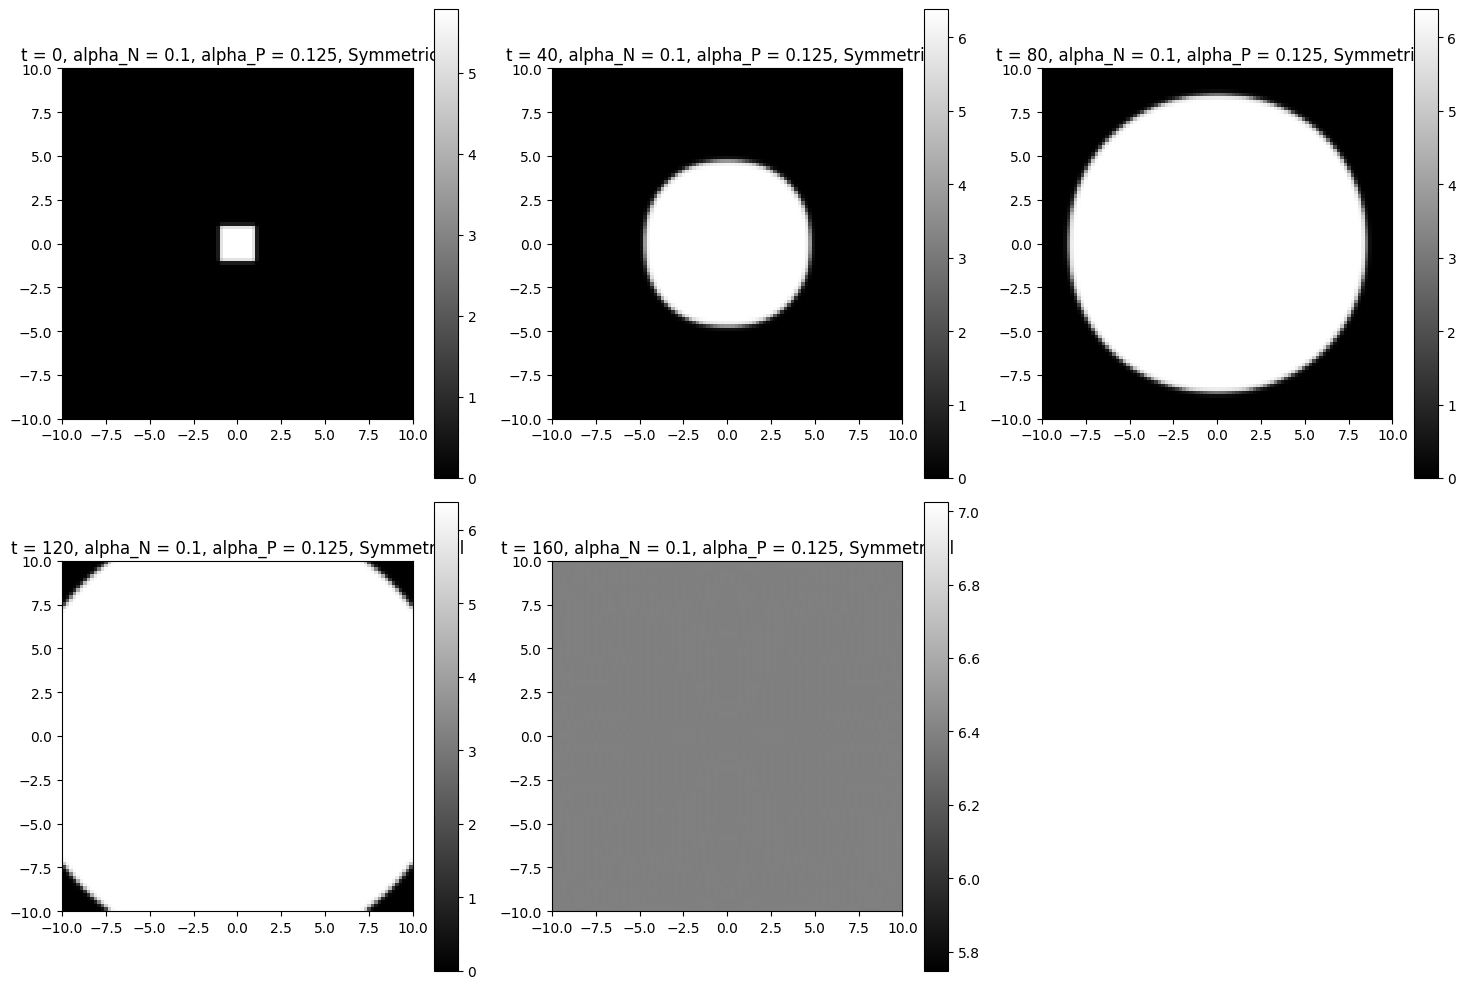

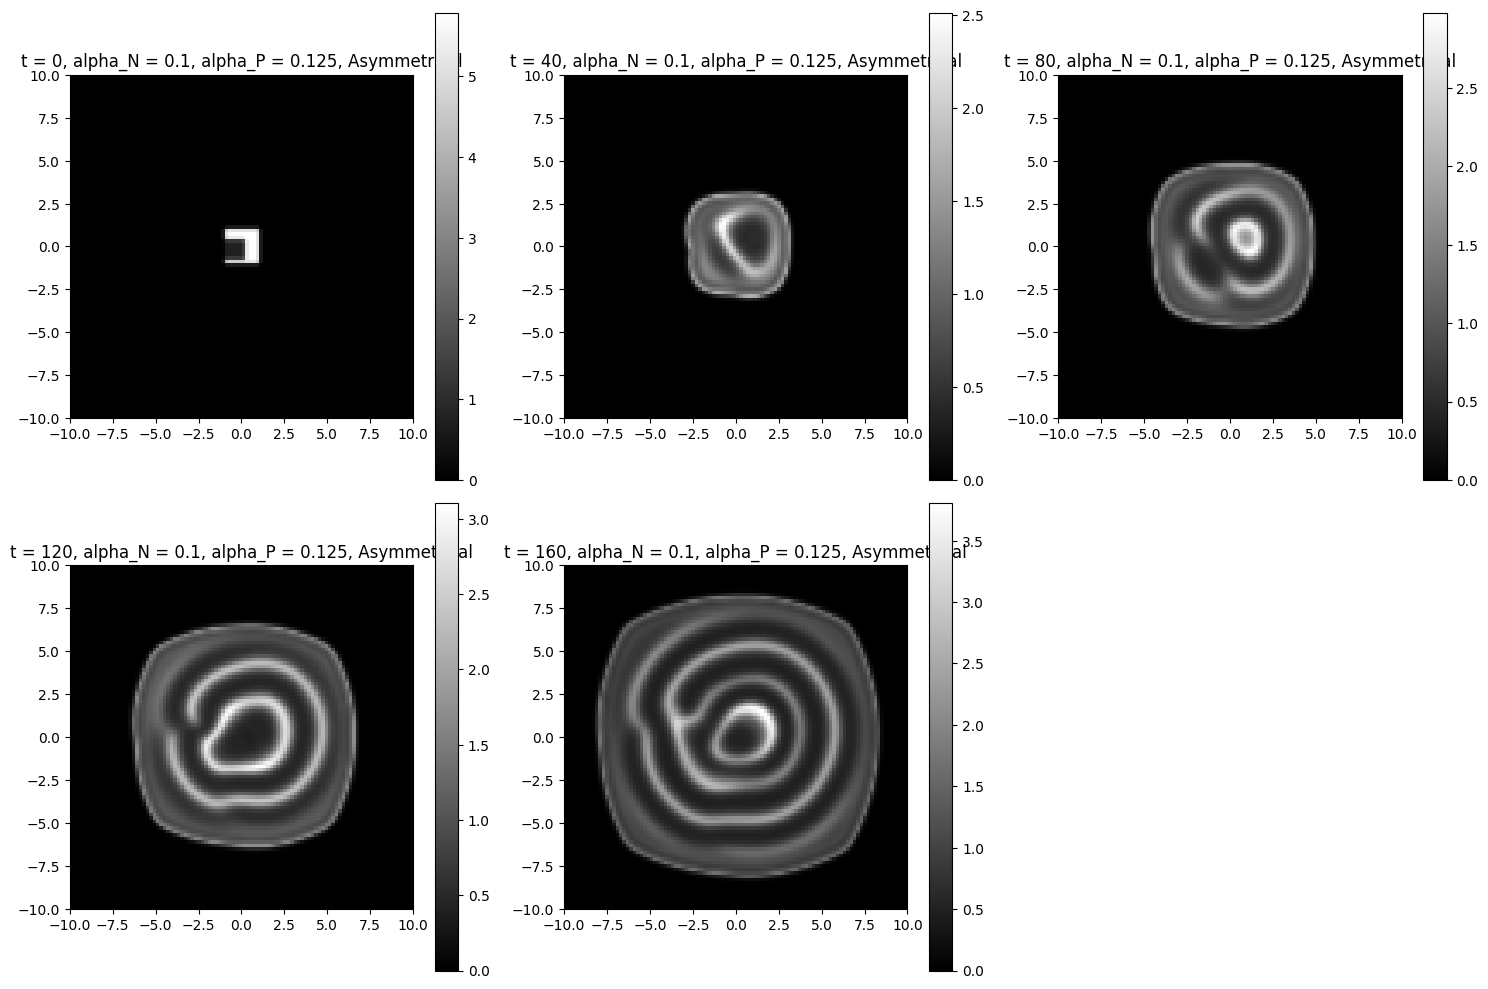

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parameters
a = 4.5
b = 0.68
L = 10
alpha_N = 0.1
alpha_P = 0.125

# Equilibrium values
N_star = (a + np.sqrt(a**2 - 4*b)) / (2 * b)
P_star = np.log(a / b + 1)

# Domain size
K = 100
x = np.linspace(-L, L, K)
y = np.linspace(-L, L, K)
X, Y = np.meshgrid(x, y)

# Initialize populations
def initialize_populations(symmetrical=True):
    N = np.zeros((K, K))
    P = np.zeros((K, K))
    if symmetrical:
        N[(X >= -1) & (X <= 1) & (Y >= -1) & (Y <= 1)] = N_star / 2
        P[(X >= -0.1) & (X <= 0.1) & (Y >= -1) & (Y <= 1)] = P_star
    else:
        N[(X >= -1) & (X <= 1) & (Y >= -1) & (Y <= 1)] = N_star / 2
        P[(X >= -1) & (X <= 0.2) & (Y >= -0.9) & (Y <= 0.4)] = P_star
    return N, P

# Dispersal function using Gaussian kernel
def dispersal(population, alpha):
    return gaussian_filter(population, sigma=alpha * K / (2 * L))

# Population dynamics functions
def f(N, P):
    return (a * N**2) / (1 + b * N**2) * np.exp(-P)

def g(N, P):
    return N * P

# Simulation
def simulate(time_steps, alpha_N, alpha_P, symmetrical=True):
    N, P = initialize_populations(symmetrical)
    for t in range(time_steps):
        N = dispersal(f(N, P), alpha_N)
        P = dispersal(g(N, P), alpha_P)
        if t % (time_steps // 5) == 0:
            yield N, t

# Visualization
def visualize(time_steps, alpha_N, alpha_P, symmetrical=True):
    plt.figure(figsize=(15, 10))
    for i, (N, t) in enumerate(simulate(time_steps, alpha_N, alpha_P, symmetrical)):
        plt.subplot(2, 3, i+1)
        plt.imshow(N, extent=(-L, L, -L, L), origin='lower', cmap='gray')
        plt.colorbar()
        plt.title(f"t = {t}, alpha_N = {alpha_N}, alpha_P = {alpha_P}, {'Symmetrical' if symmetrical else 'Asymmetrical'}")
    plt.tight_layout()
    plt.show()

# Run and visualize simulations
visualize(200, 0.1, 0.125, symmetrical=True)
visualize(200, 0.1, 0.125, symmetrical=False)


# Sensitivity of Initial Conditions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


In [4]:
# Parameters
a = 4.5
b = 0.68
L = 10
alpha_N = 0.1
alpha_P = 0.125
dx = 0.1
dy = 0.1

# Domain
x = np.arange(-L, L, dx)
y = np.arange(-L, L, dy)
X, Y = np.meshgrid(x, y)

# Local interaction functions
def f(N, P):
    return (a * N**2) / (1 + b * N**2) * np.exp(-P)

def g(N, P):
    return N * P

# Dispersal kernels
def K_N(x, y):
    return (1 / (2 * np.pi * alpha_N**2)) * np.exp(-((x**2 + y**2) / (2 * alpha_N**2)))

def K_P(x, y):
    return (1 / (2 * np.pi * alpha_P**2)) * np.exp(-((x**2 + y**2) / (2 * alpha_P**2)))


In [5]:
# Initial conditions
N_star = (a + np.sqrt(a**2 - 4*b)) / (2*b)
P_star = np.log(a / (b + 1))

N0 = np.zeros_like(X)
P0 = np.zeros_like(X)

N0[(X >= -1) & (X <= 1) & (Y >= -1) & (Y <= 1)] = N_star / 2
P0[(X >= -0.1) & (X <= 0.1) & (Y >= -1) & (Y <= 1)] = P_star


In [6]:
def update_population(N, P):
    N_new = np.zeros_like(N)
    P_new = np.zeros_like(P)

    for i in range(N.shape[0]):
        for j in range(N.shape[1]):
            convolution_N = np.sum(K_N(X - x[i], Y - y[j]) * f(N, P) * dx * dy)
            convolution_P = np.sum(K_P(X - x[i], Y - y[j]) * g(N, P) * dx * dy)

            N_new[i, j] = convolution_N
            P_new[i, j] = convolution_P

    return N_new, P_new


In [7]:
# Number of generations
generations = 50

# populations over time
N_pop = [N0]
P_pop = [P0]

N, P = N0, P0
for t in range(generations):
    N, P = update_population(N, P)
    N_pop.append(N)
    P_pop.append(P)


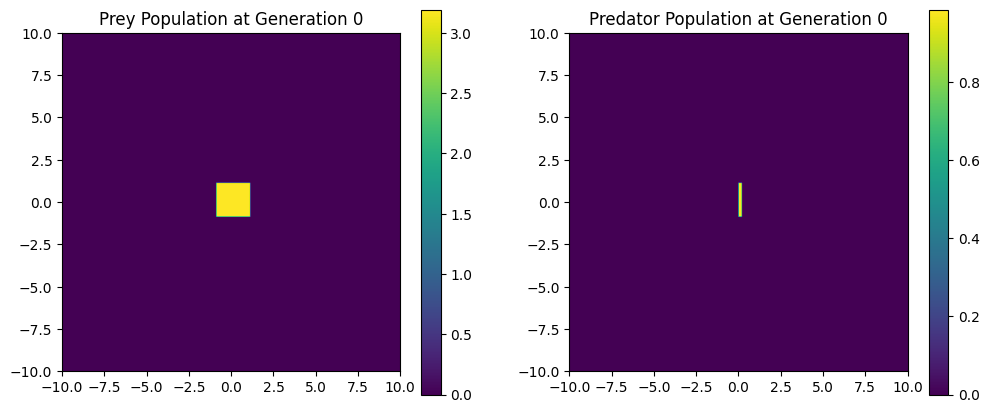

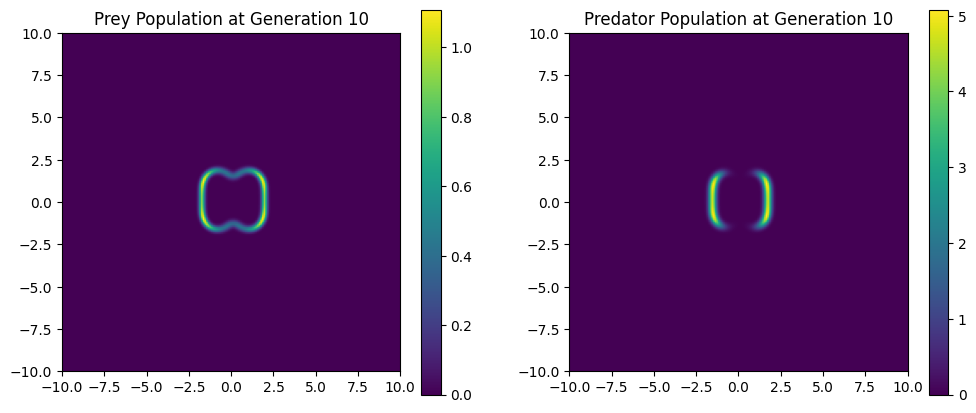

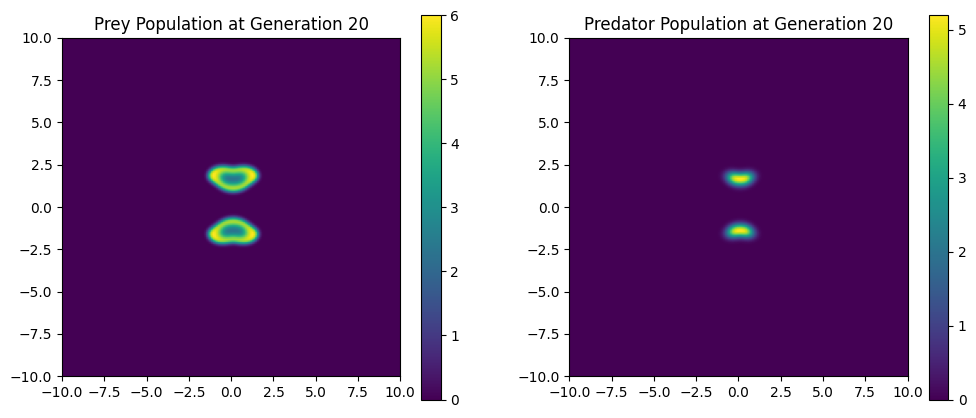

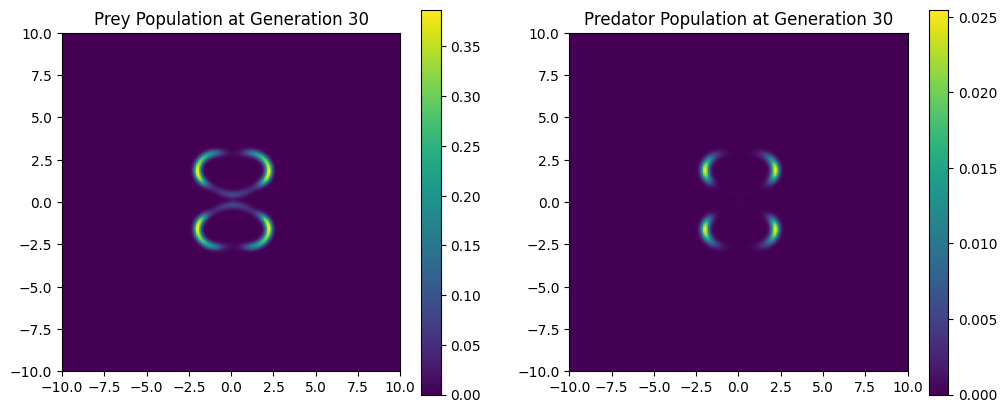

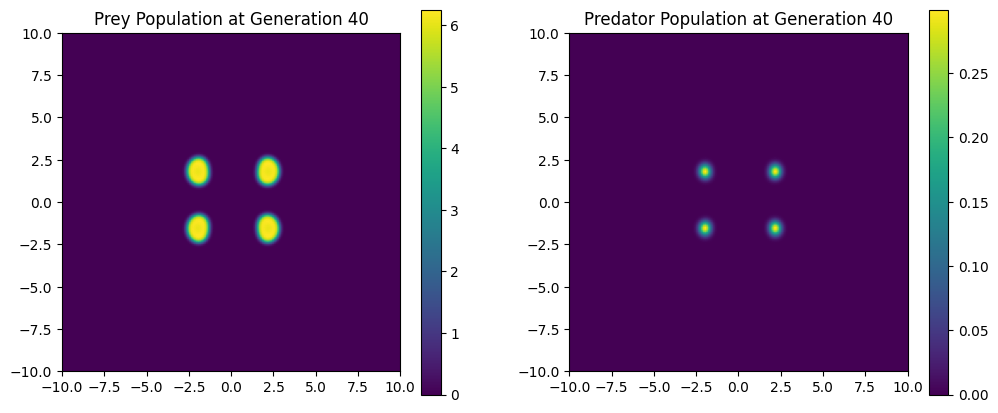

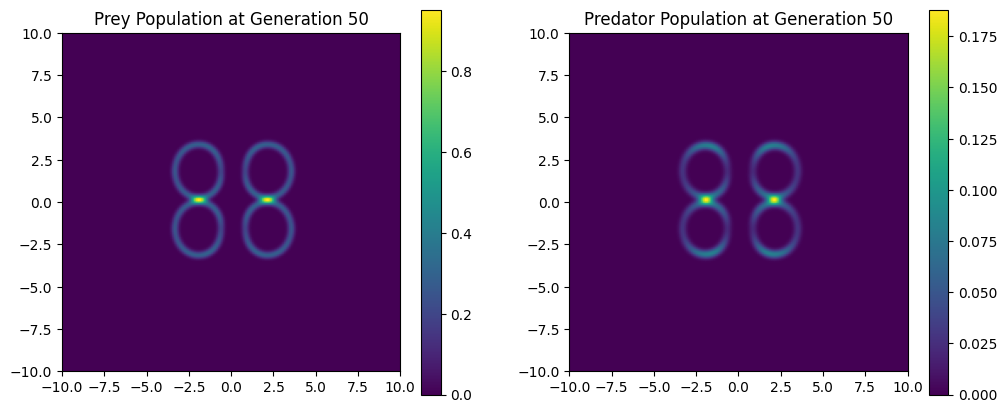

In [8]:
def plot_populations(N_pop, P_pop, generations, interval=10):
    for t in range(0, generations + 1, interval):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.title(f"Prey Population at Generation {t}")
        plt.imshow(N_pop[t], extent=(-L, L, -L, L), origin='lower')
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title(f"Predator Population at Generation {t}")
        plt.imshow(P_pop[t], extent=(-L, L, -L, L), origin='lower')
        plt.colorbar()

        plt.show()

# Plot the populations
plot_populations(N_pop, P_pop, generations)


# **Rate of spread**

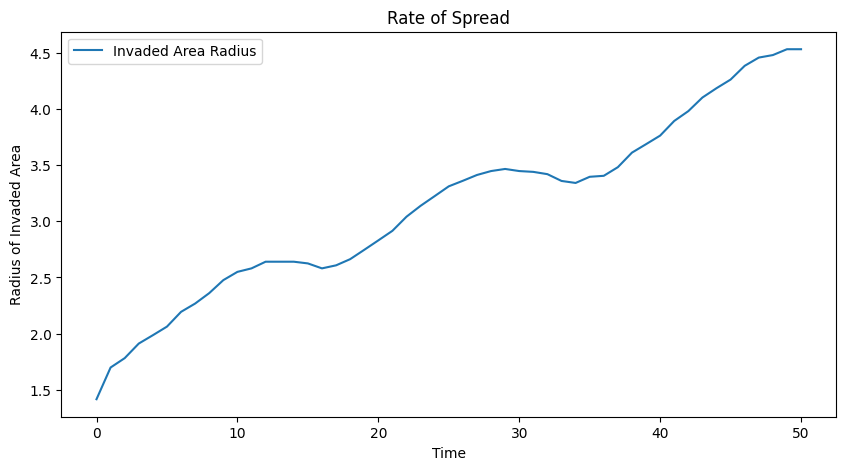

In [9]:
def calculate_radius(N_pop, threshold):
    radius = []
    for N in N_pop:
        invaded_positions = np.where(N >= threshold)
        if len(invaded_positions[0]) > 0:
            max_distance = np.max(np.sqrt((X[invaded_positions]**2 + Y[invaded_positions]**2)))
            radius.append(max_distance)
        else:
            radius.append(0)
    return radius

def plot_radius(radius, generations, interval=10):
    plt.figure(figsize=(10, 5))
    plt.plot(range(generations + 1), radius, label='Invaded Area Radius')
    plt.xlabel('Time')
    plt.ylabel('Radius of Invaded Area')
    plt.title('Rate of Spread')
    plt.legend()
    plt.show()

# Calculate and plot the radius
threshold = 0.01
radius = calculate_radius(N_pop, threshold)
plot_radius(radius, generations)


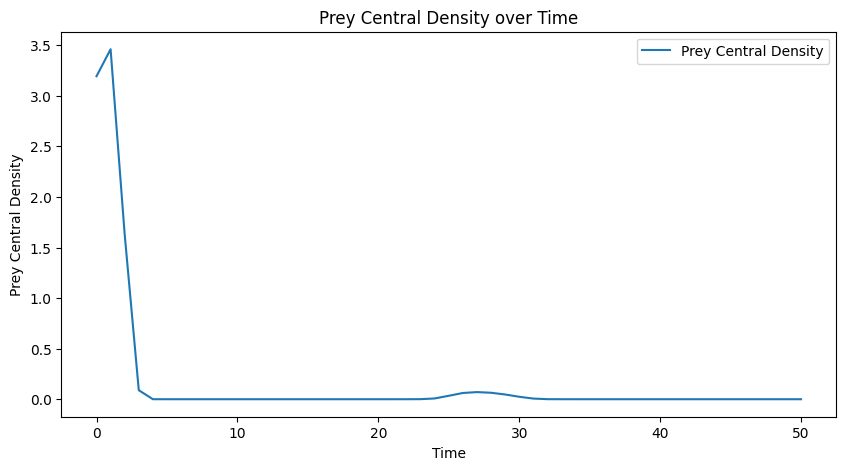

In [10]:
generations = len(N_pop) - 1

# Calculate central density from stored data
central_density = [N[N.shape[0] // 2, N.shape[1] // 2] for N in N_pop]

def plot_central_density(central_density, generations):
    plt.figure(figsize=(10, 5))
    plt.plot(range(generations + 1), central_density, label='Prey Central Density')
    plt.xlabel('Time')
    plt.ylabel('Prey Central Density')
    plt.title('Prey Central Density over Time')
    plt.legend()
    plt.show()

# Plot the central density
plot_central_density(central_density, generations)

# **Predator prey central density**

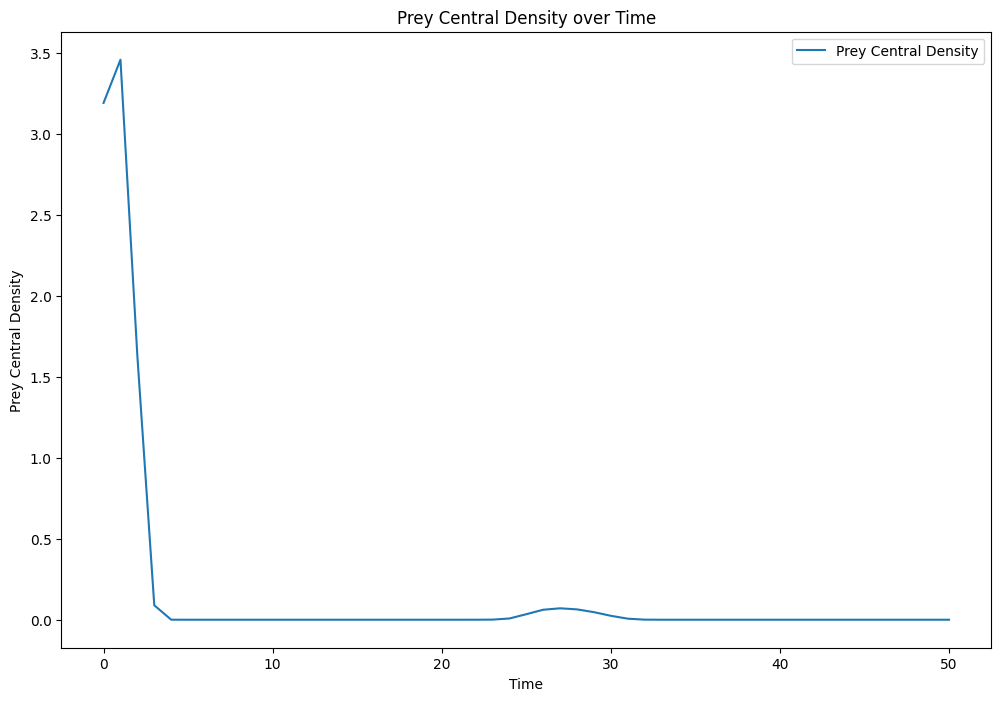

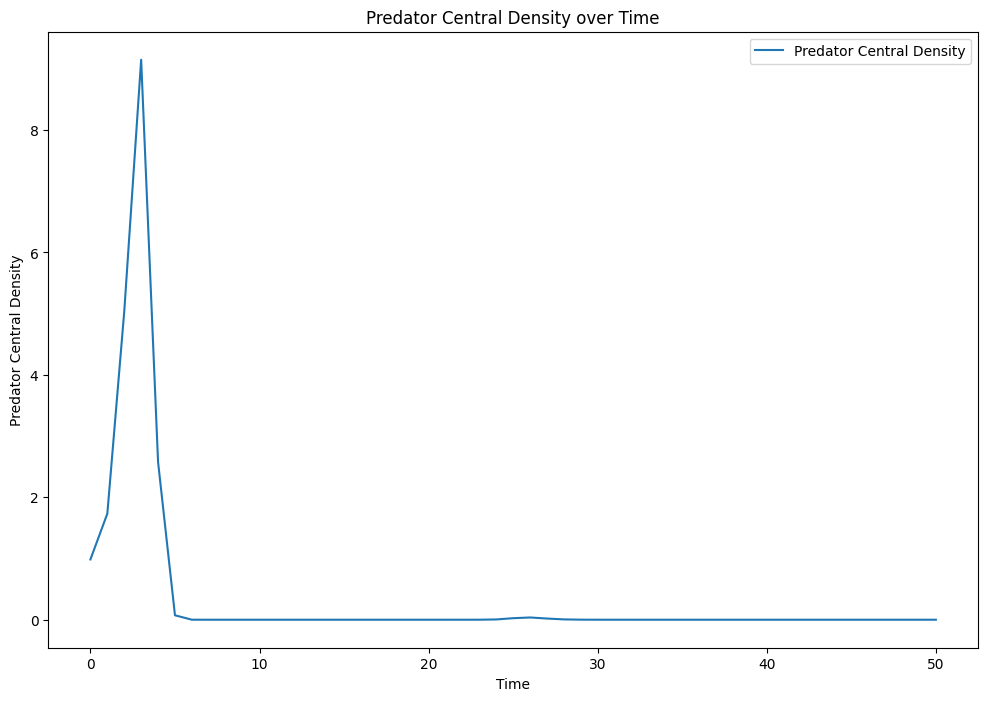

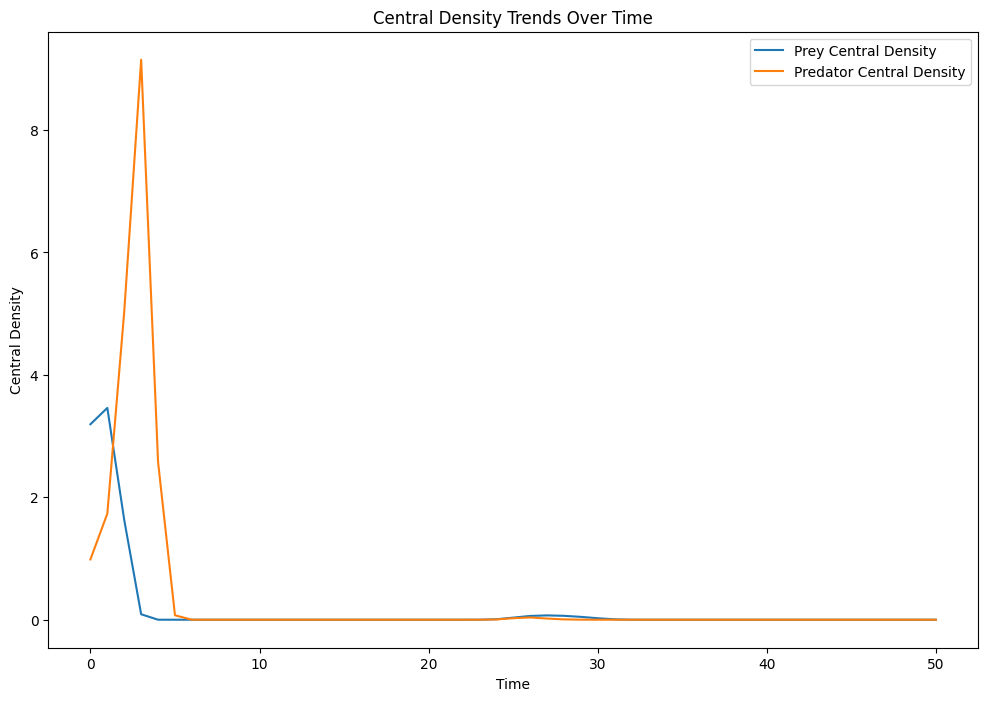

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following are defined and calculated as previously:
# - N_pop: List of prey population matrices over generations
# - P_pop: List of predator population matrices over generations

# Number of generations
generations = len(N_pop) - 1

# Calculate central density from stored data
prey_central_density = [N[N.shape[0] // 2, N.shape[1] // 2] for N in N_pop]
predator_central_density = [P[P.shape[0] // 2, P.shape[1] // 2] for P in P_pop]

# Intervals to plot
intervals = [0, 10, 20, 30, 40, 50]

# Plot prey central density over generations at specific intervals
plt.figure(figsize=(12, 8))
plt.plot(range(generations + 1), prey_central_density, label='Prey Central Density')
plt.xlabel('Time')
plt.ylabel('Prey Central Density')
plt.title('Prey Central Density over Time')
plt.legend()
plt.show()

# Plot predator central density over generations at specific intervals
plt.figure(figsize=(12, 8))
plt.plot(range(generations + 1), predator_central_density, label='Predator Central Density')
plt.xlabel('Time')
plt.ylabel('Predator Central Density')
plt.title('Predator Central Density over Time')
plt.legend()
plt.show()

# Combined plot for prey and predator central densities
def plot_central_density_trends(prey_density, predator_density, generations):
    plt.figure(figsize=(12, 8))
    plt.plot(range(generations + 1), prey_density, label='Prey Central Density')
    plt.plot(range(generations + 1), predator_density, label='Predator Central Density')
    plt.xlabel('Time')
    plt.ylabel('Central Density')
    plt.title('Central Density Trends Over Time')
    plt.legend()
    plt.show()

# Plot the trend lines of central density over time
plot_central_density_trends(prey_central_density, predator_central_density, generations)


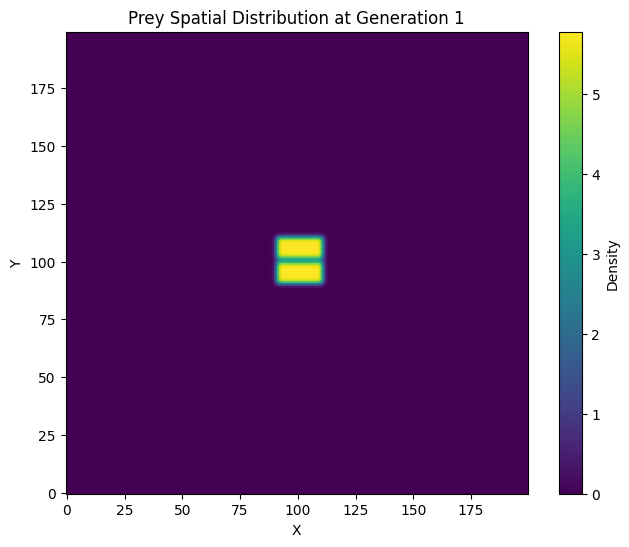

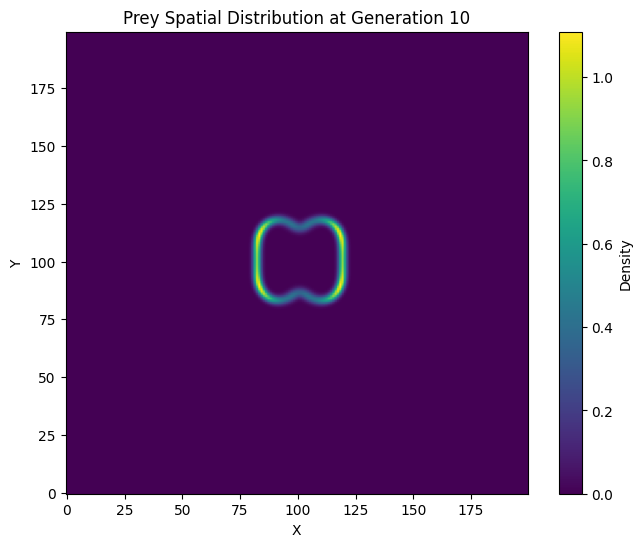

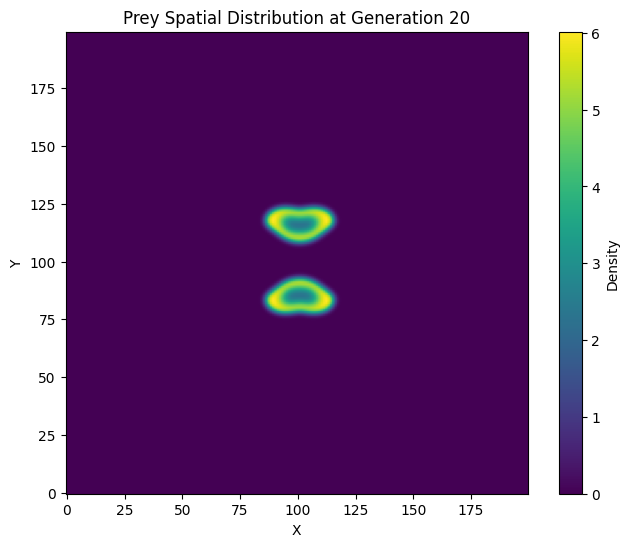

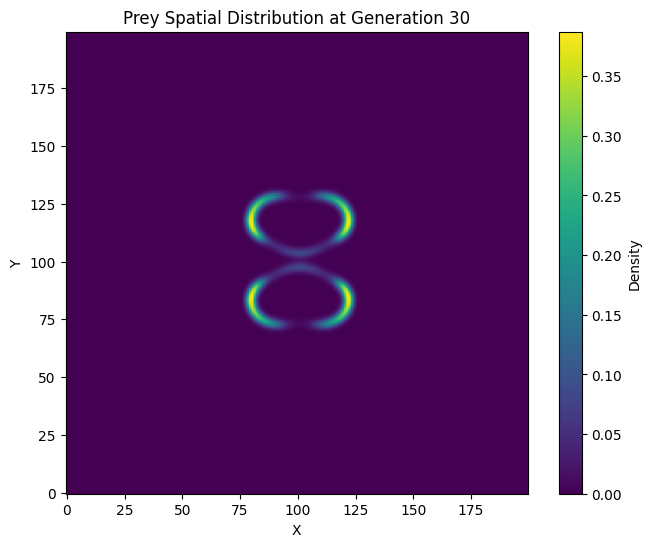

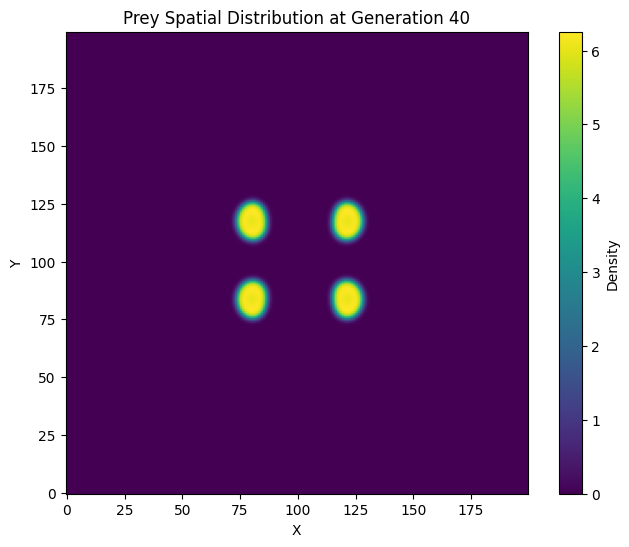

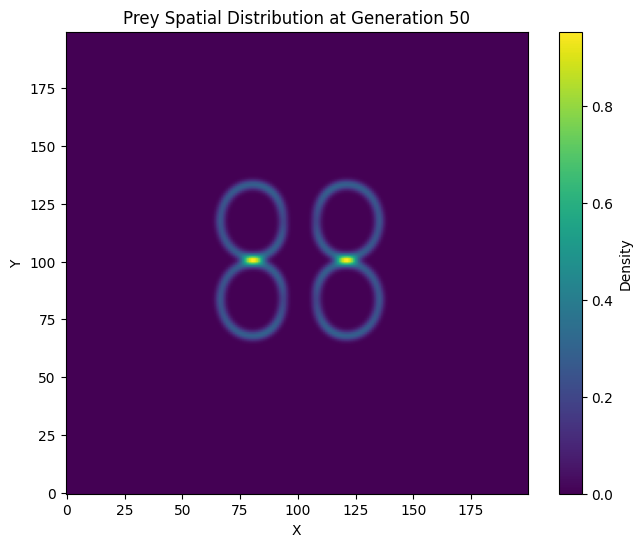

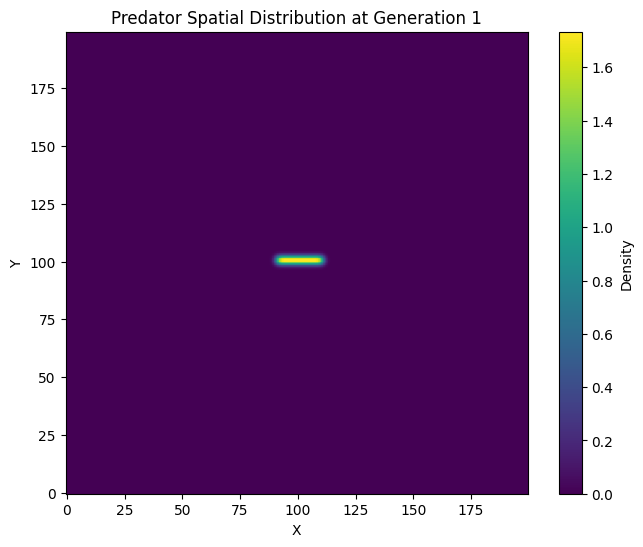

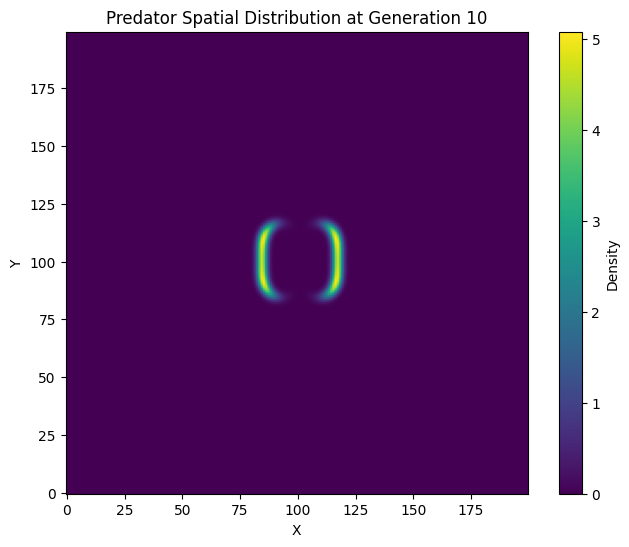

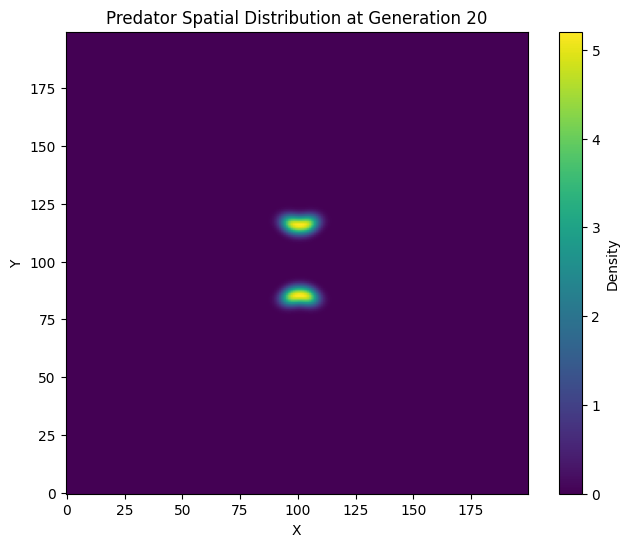

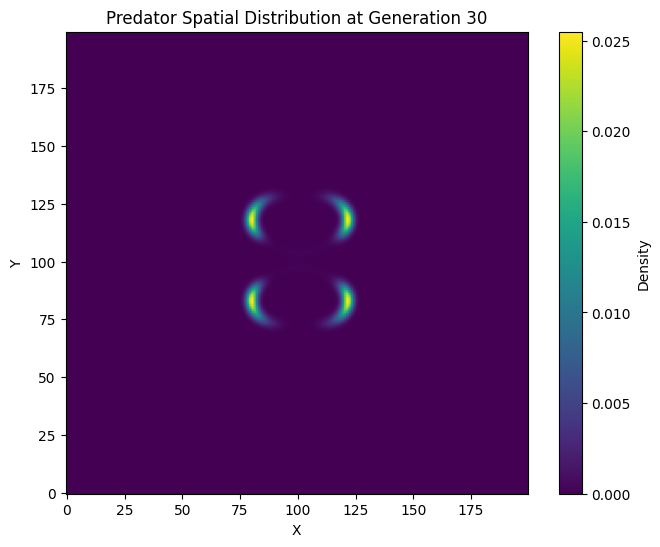

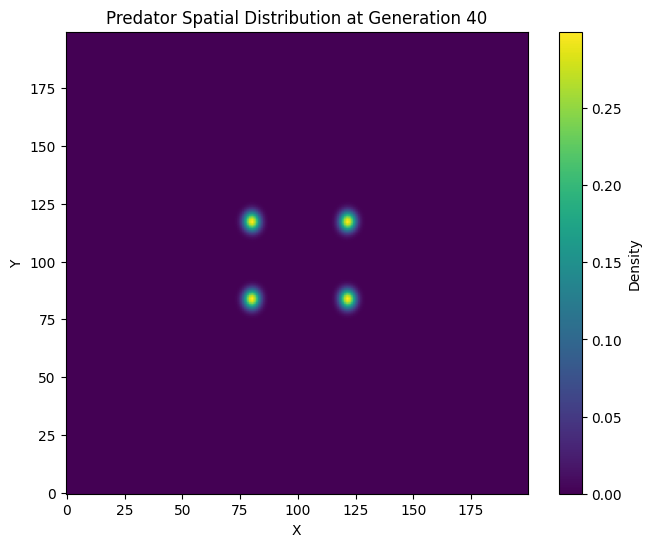

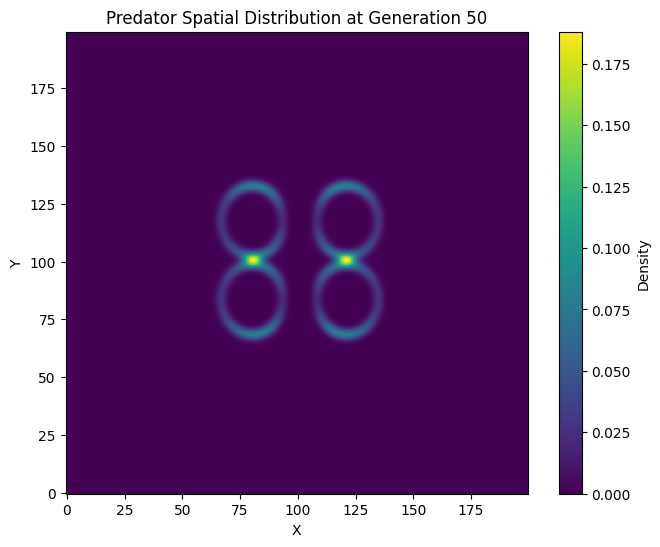

In [14]:
intervals = [1, 10, 20, 30, 40, 50]

# Function to plot spatial distribution heatmaps
def plot_spatial_distribution(populations, intervals, title_prefix):
    for t in intervals:
        plt.figure(figsize=(8, 6))
        plt.imshow(populations[t], cmap='viridis', origin='lower')
        plt.colorbar(label='Density')
        plt.title(f'{title_prefix} Spatial Distribution at Generation {t}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

# Plot spatial distribution for prey
plot_spatial_distribution(N_pop, intervals, 'Prey')

# Plot spatial distribution for predator
plot_spatial_distribution(P_pop, intervals, 'Predator')

# **Sensitivity  Tests**

In [15]:
perturbation = 0.01

N0_perturbed = N0 + perturbation * np.random.normal(size=N0.shape)
P0_perturbed = P0 + perturbation * np.random.normal(size=P0.shape)

N0_perturbed = np.clip(N0_perturbed, 0, None)
P0_perturbed = np.clip(P0_perturbed, 0, None)


In [16]:

generations = 50

N_pop_perturbed = [N0_perturbed]
P_pop_perturbed = [P0_perturbed]
central_density_perturbed = [N0_perturbed[N0_perturbed.shape[0] // 2, N0_perturbed.shape[1] // 2]]

N_perturbed, P_perturbed = N0_perturbed, P0_perturbed
for t in range(generations):
    N_perturbed, P_perturbed = update_population(N_perturbed, P_perturbed)
    N_pop_perturbed.append(N_perturbed)
    P_pop_perturbed.append(P_perturbed)
    central_density_perturbed.append(N_perturbed[N_perturbed.shape[0] // 2, N_perturbed.shape[1] // 2])


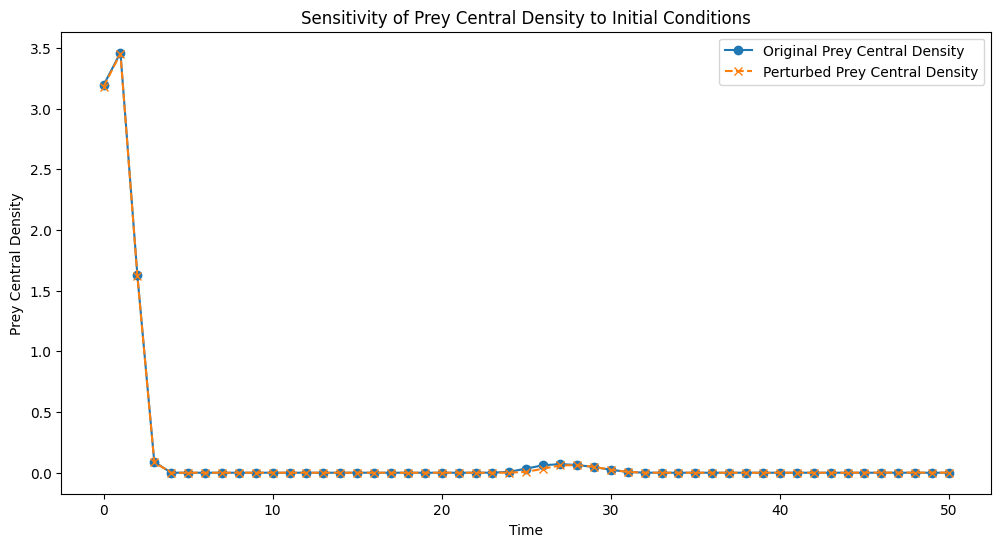

In [18]:
# central density for the original data
central_density_original = [N[N.shape[0] // 2, N.shape[1] // 2] for N in N_pop]

# central density for the perturbed data
central_density_perturbed = [N[N.shape[0] // 2, N.shape[1] // 2] for N in N_pop_perturbed]

# Plot central density comparison
plt.figure(figsize=(12, 6))
plt.plot(range(generations + 1), central_density_original, label='Original Prey Central Density', linestyle='-', marker='o')
plt.plot(range(generations + 1), central_density_perturbed, label='Perturbed Prey Central Density', linestyle='--', marker='x')
plt.xlabel('Time')
plt.ylabel('Prey Central Density')
plt.title('Sensitivity of Prey Central Density to Initial Conditions')
plt.legend()
plt.show()


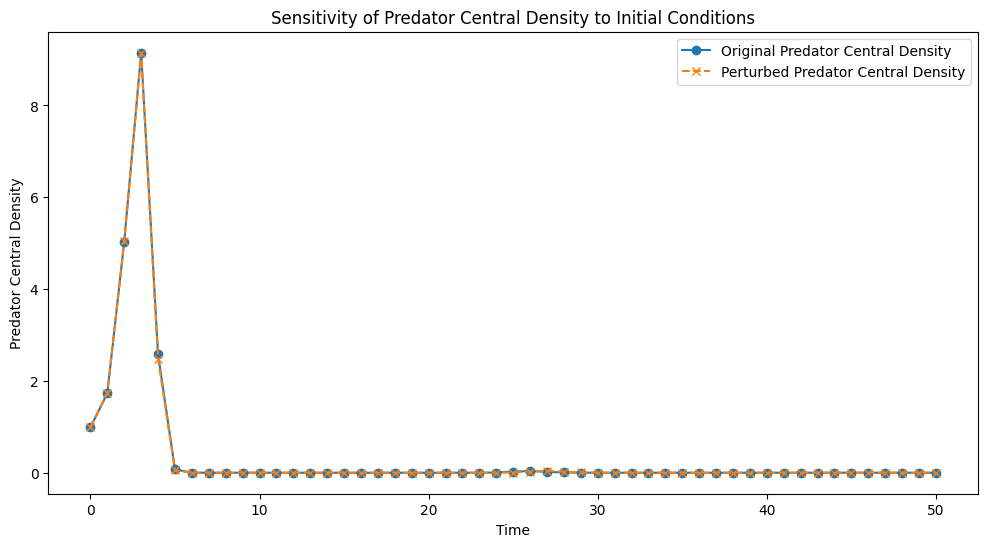

In [20]:
# Central density for the original predator data
central_density_original_predator = [P[P.shape[0] // 2, P.shape[1] // 2] for P in P_pop]

# Central density for the perturbed predator data
central_density_perturbed_predator = [P[P.shape[0] // 2, P.shape[1] // 2] for P in P_pop_perturbed]

# Plot predator central density comparison
plt.figure(figsize=(12, 6))
plt.plot(range(generations + 1), central_density_original_predator, label='Original Predator Central Density', linestyle='-', marker='o')
plt.plot(range(generations + 1), central_density_perturbed_predator, label='Perturbed Predator Central Density', linestyle='--', marker='x')
plt.xlabel('Time')
plt.ylabel('Predator Central Density')
plt.title('Sensitivity of Predator Central Density to Initial Conditions')
plt.legend()
plt.show()


**ORIGINAL VS PERTURBED**

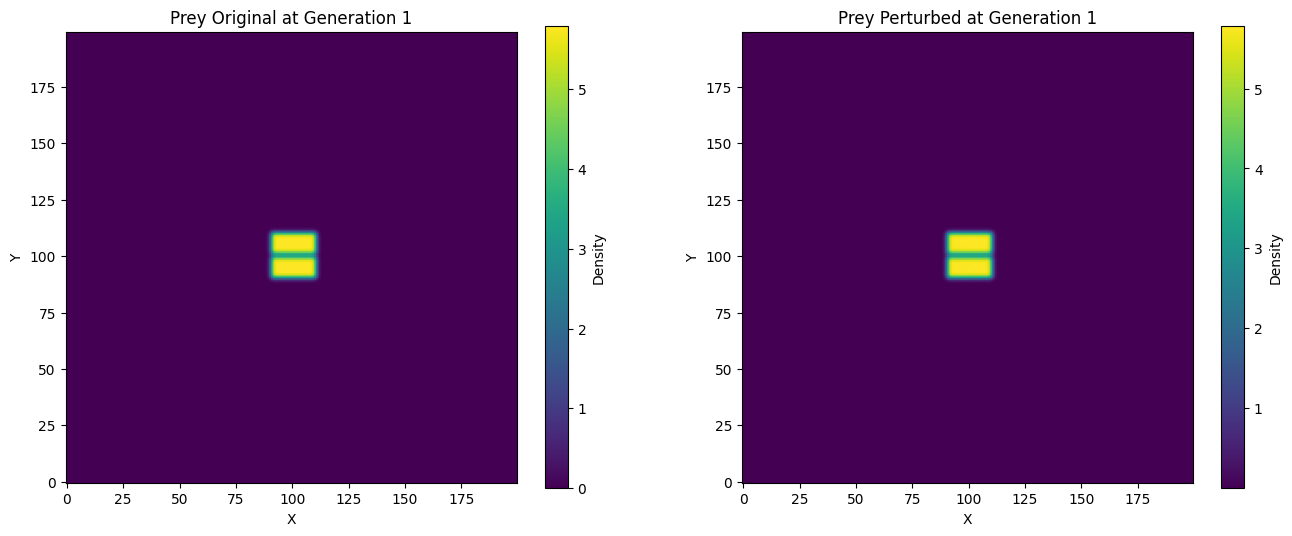

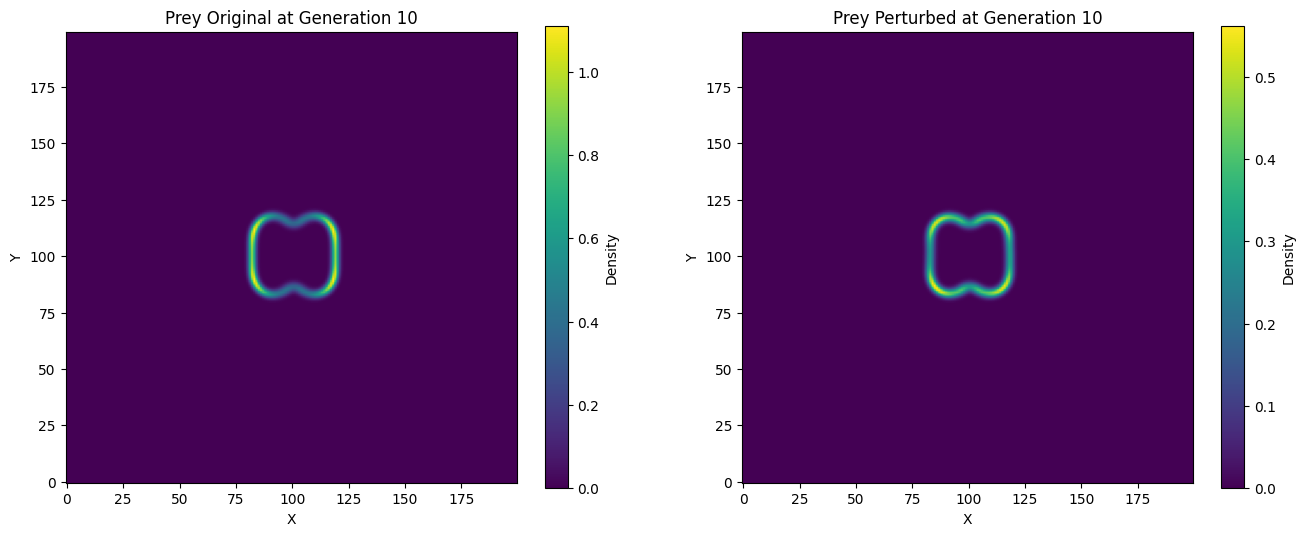

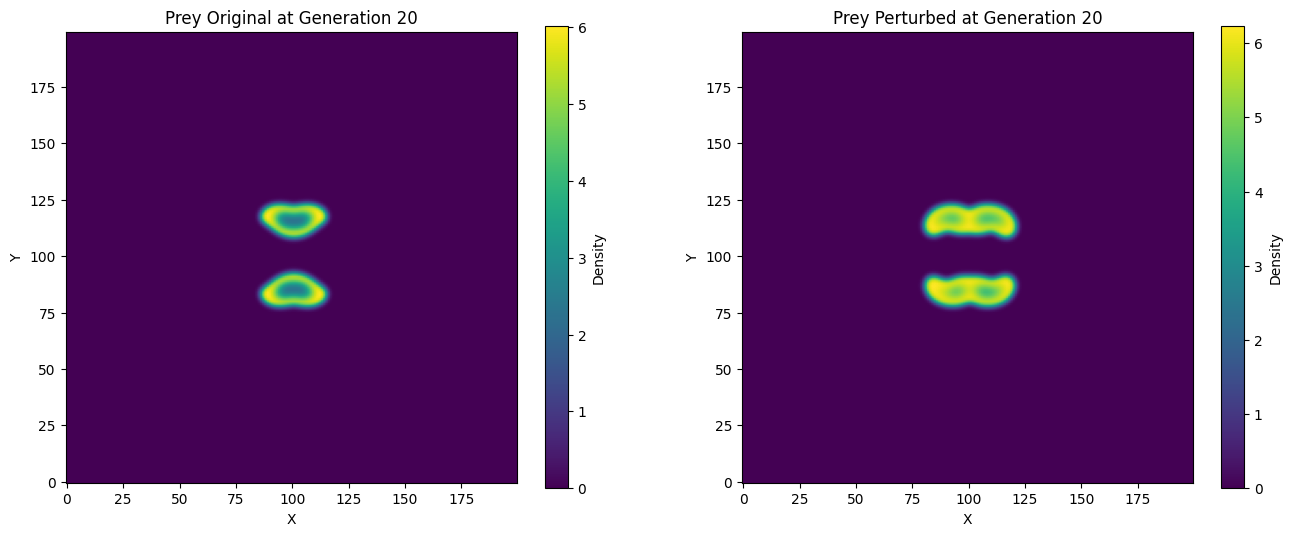

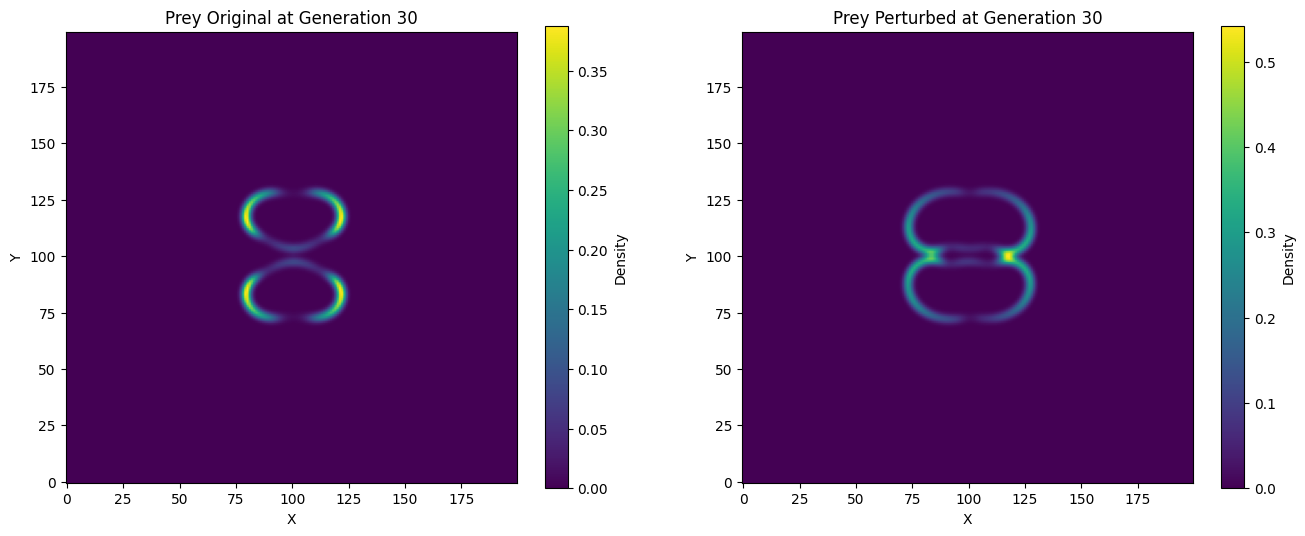

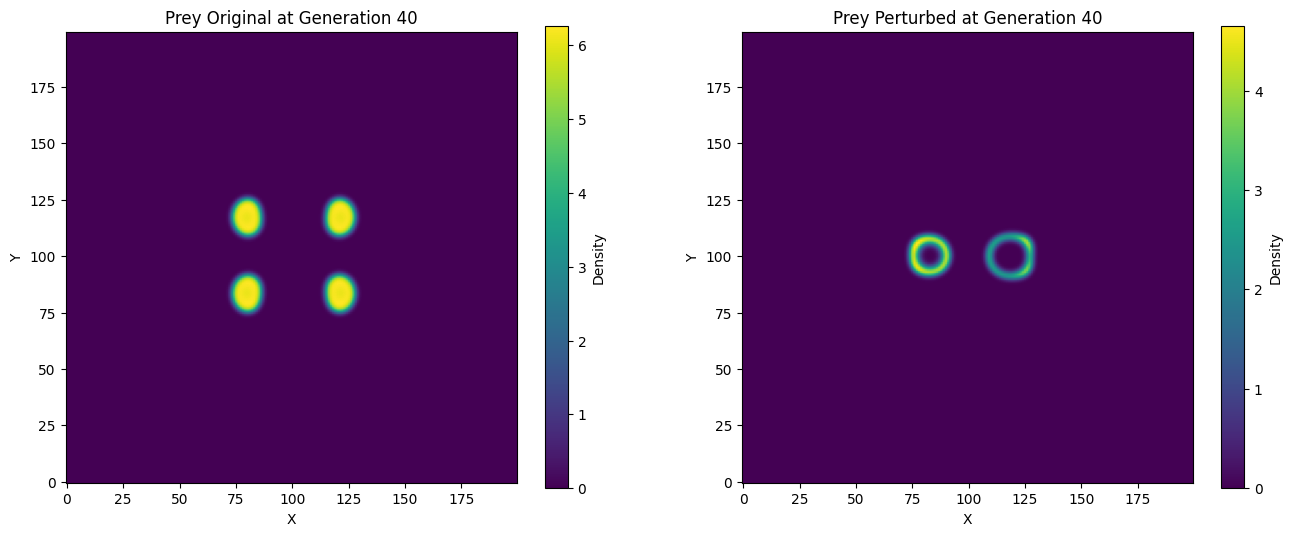

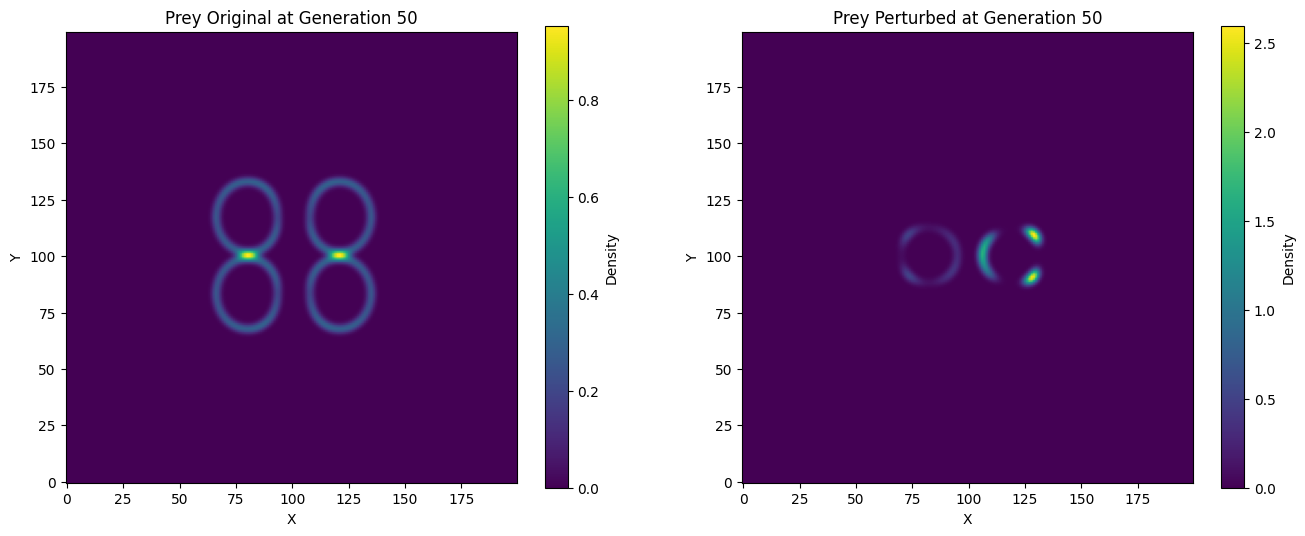

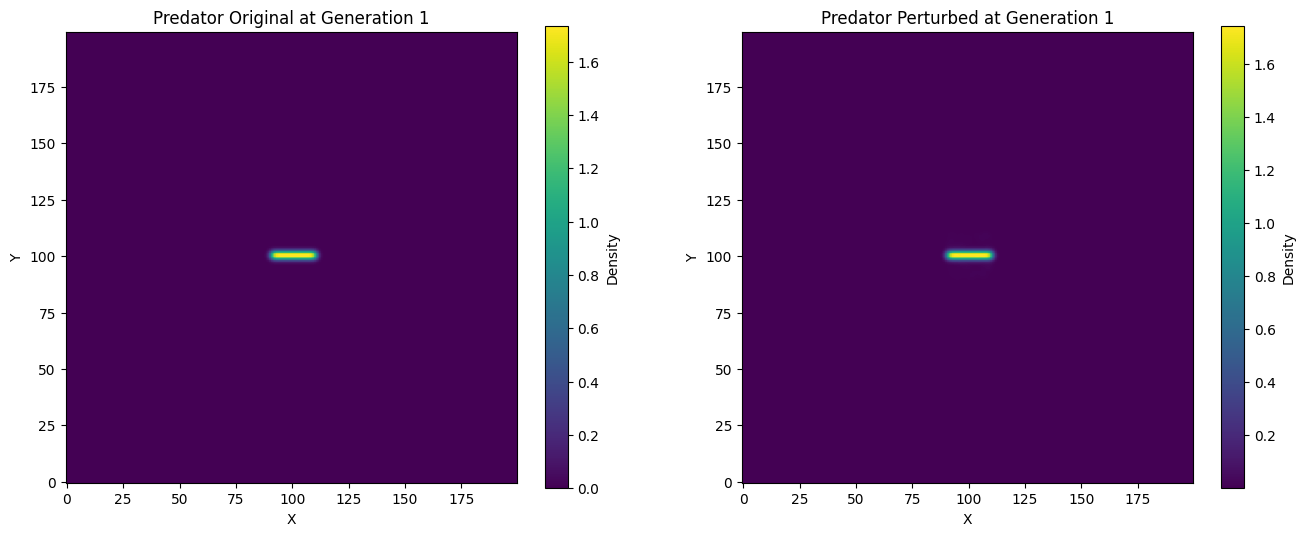

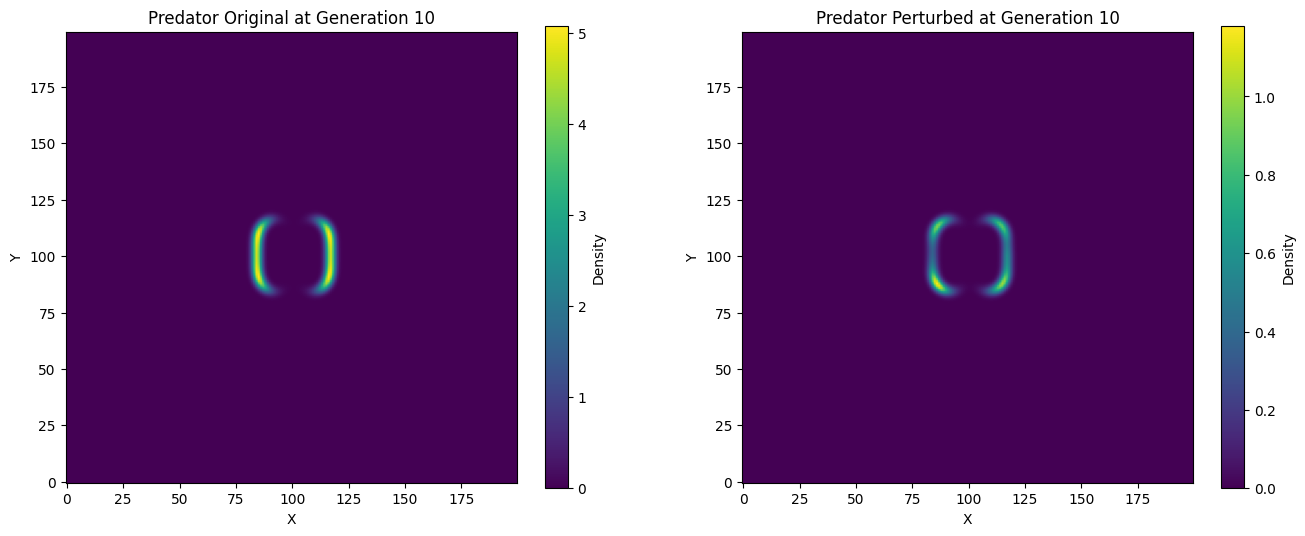

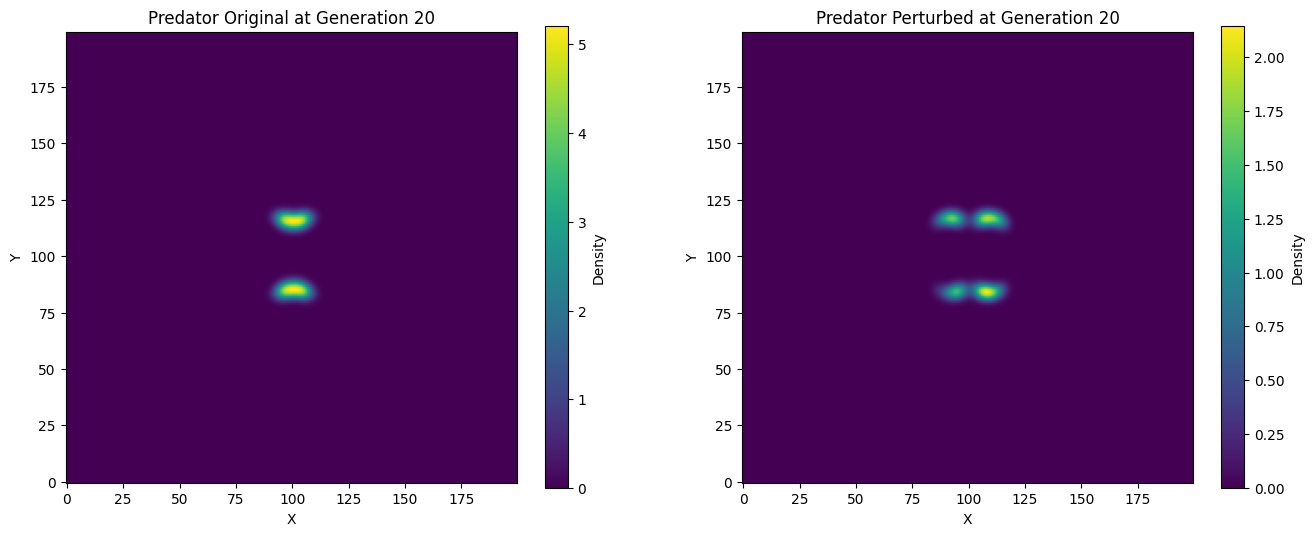

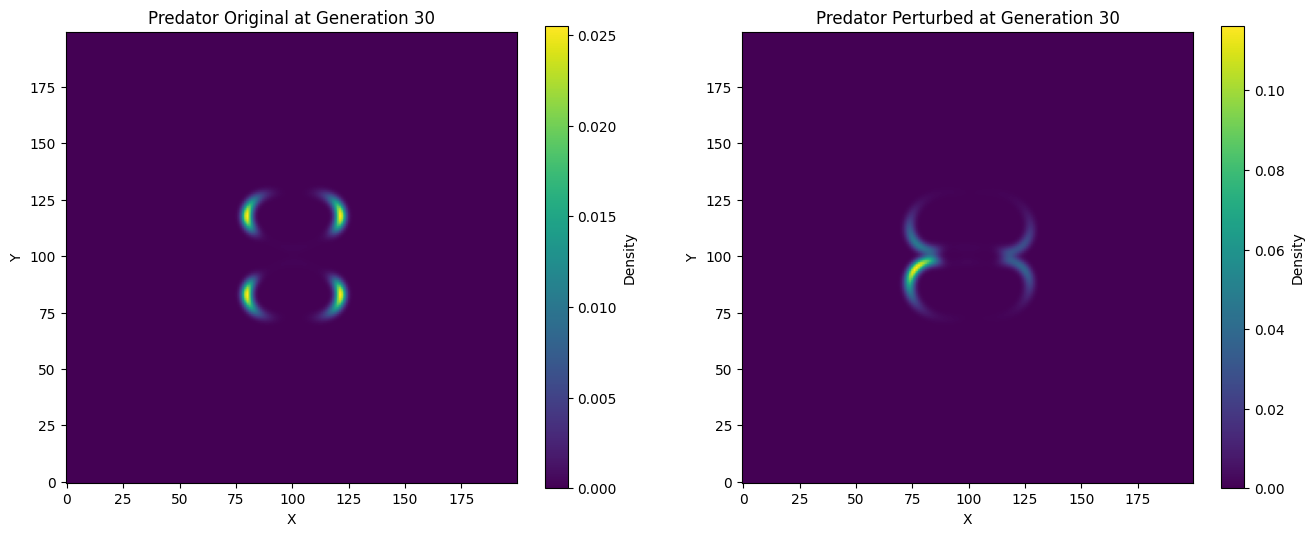

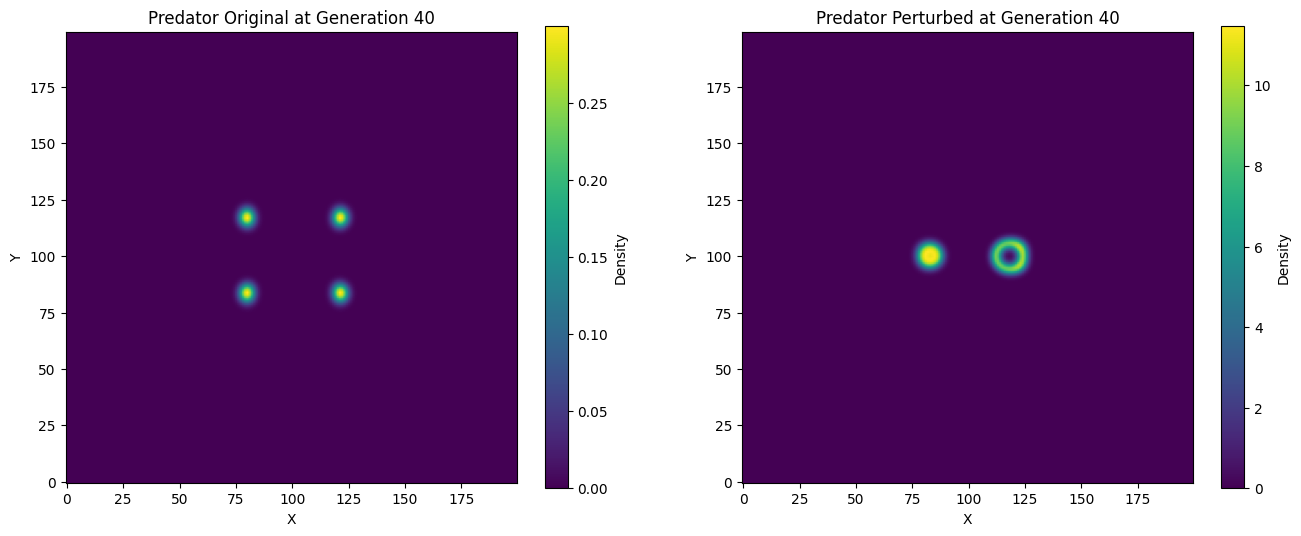

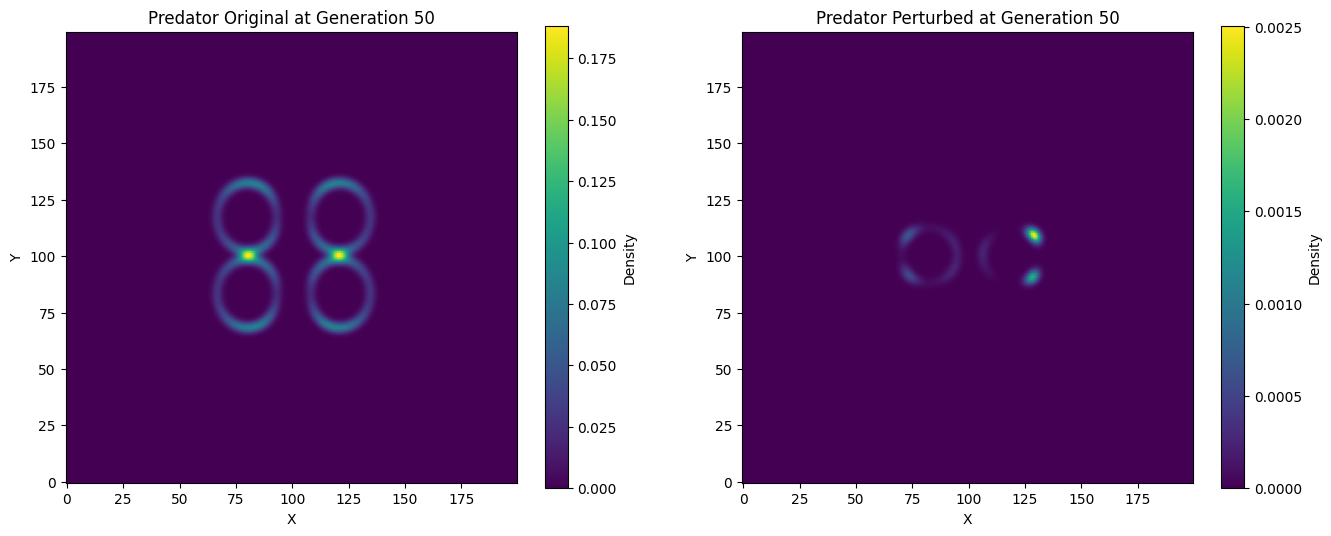

In [21]:
import matplotlib.pyplot as plt

# Intervals to plot
intervals = [1, 10, 20, 30, 40, 50]

# Function to plot spatial distribution heatmaps
def plot_spatial_distribution_comparison(original_pop, perturbed_pop, intervals, title_prefix):
    for t in intervals:
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # Original
        im0 = axs[0].imshow(original_pop[t], cmap='viridis', origin='lower')
        axs[0].set_title(f'{title_prefix} Original at Generation {t}')
        axs[0].set_xlabel('X')
        axs[0].set_ylabel('Y')
        fig.colorbar(im0, ax=axs[0], label='Density')

        # Perturbed
        im1 = axs[1].imshow(perturbed_pop[t], cmap='viridis', origin='lower')
        axs[1].set_title(f'{title_prefix} Perturbed at Generation {t}')
        axs[1].set_xlabel('X')
        axs[1].set_ylabel('Y')
        fig.colorbar(im1, ax=axs[1], label='Density')

        plt.show()

# Plot spatial distribution comparison for prey
plot_spatial_distribution_comparison(N_pop, N_pop_perturbed, intervals, 'Prey')

# Plot spatial distribution comparison for predator
plot_spatial_distribution_comparison(P_pop, P_pop_perturbed, intervals, 'Predator')
